In [1]:
#using Pkg; Pkg.add("ImageView")
using LinearAlgebra, RowEchelon, LaTeXStrings, Plots, SymPy
using Random, Distributions, Images, TestImages, Colors, ImageView

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">Randomized Linear Algebra</strong></div>

# 1. Images are Matrices

## 1.1 Display a Matrix

4×3 Matrix{Float64}:
 0.234245  0.407076  0.996575
 0.420671  0.156991  0.0532626
 0.929443  0.183238  0.706566
 0.156102  0.2008    0.349744

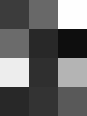

In [2]:
A = rand(4,3)
display(A)
Gray.(A)

## 1.2 A Color Image

Image type: Matrix{RGB{N0f8}}


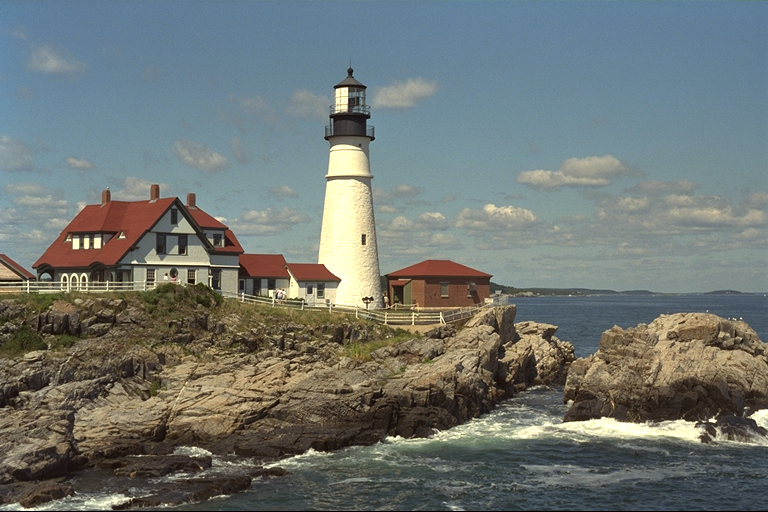

In [3]:
img = testimage("lighthouse")
println("Image type: ", typeof(img))
img

##### **RGB Channels**

In [4]:
channels = channelview(img)
println("channels type: ", typeof(channels[1,:,:]))
channels

channels type: Matrix{N0f8}


3×512×768 reinterpret(reshape, N0f8, ::Array{RGB{N0f8},2}) with eltype N0f8:
[:, :, 1] =
 0.361  0.361  0.376  0.365  0.365  0.369  …  0.663  0.702  0.459  0.443  0.0
 0.486  0.486  0.514  0.498  0.498  0.502     0.682  0.745  0.486  0.467  0.0
 0.6    0.6    0.624  0.62   0.627  0.635     0.627  0.678  0.447  0.439  0.0

[:, :, 2] =
 0.349  0.361  0.353  0.369  0.376  0.376  …  0.745  0.678  0.427  0.443  0.0
 0.475  0.498  0.49   0.506  0.51   0.51      0.776  0.722  0.467  0.467  0.0
 0.588  0.608  0.608  0.624  0.639  0.631     0.725  0.667  0.424  0.439  0.0

[:, :, 3] =
 0.345  0.361  0.361  0.365  0.361  0.365  …  0.843  0.616  0.514  0.486  0.0
 0.478  0.494  0.494  0.498  0.494  0.498     0.871  0.655  0.553  0.525  0.0
 0.588  0.616  0.616  0.62   0.616  0.62      0.82   0.612  0.518  0.49   0.0

;;; … 

[:, :, 766] =
 0.329  0.357  0.357  0.349  0.361  0.357  …  0.208  0.259  0.192  0.173  0.0
 0.463  0.486  0.482  0.475  0.486  0.482     0.255  0.31   0.231  0.204  0.0
 0.5

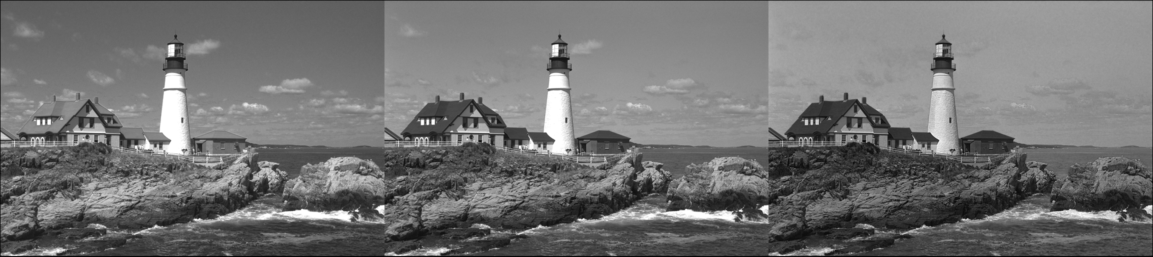

In [5]:
mosaicview( Gray.(channels[1,:,:]), Gray.(channels[2,:,:]), Gray.(channels[3,:,:]); nrow=1)

##### **Grayscale Image**

5×3 Matrix{Float64}:
 0.462745  0.45098   0.45098
 0.462745  0.470588  0.466667
 0.486275  0.462745  0.466667
 0.470588  0.478431  0.470588
 0.47451   0.486275  0.466667

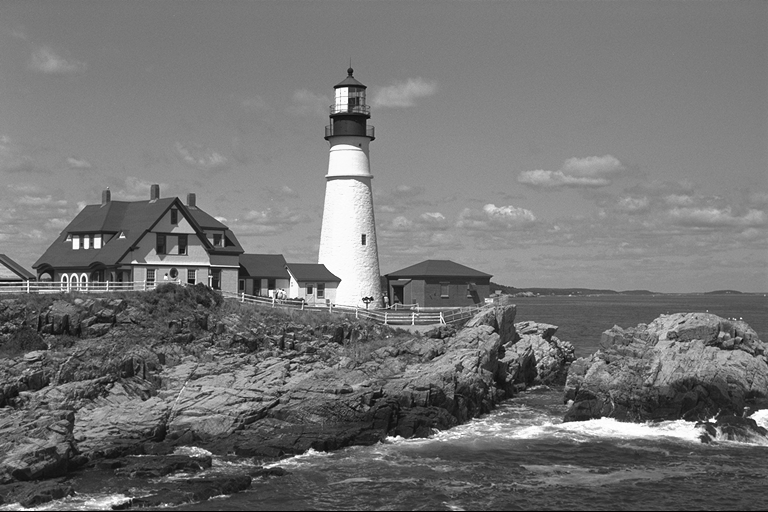

In [6]:
gray = Gray.(img)
display(Float64.(gray[1:5,1:3]))
gray

##### **Image Size and Singular Values**

In [7]:
# define matrix A to be the grayscale matrix
A = Float64.(gray);
print("shape of A: ", size(A), ",   type of A: ", typeof(A))

shape of A: (512, 768),   type of A: Matrix{Float64}

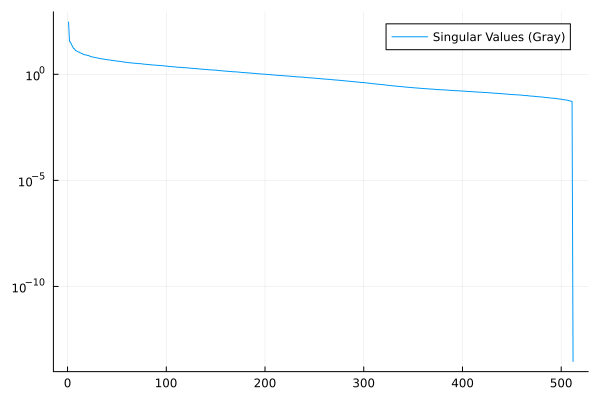

In [8]:
svdfactors = svd(Float64.(gray))
plot(  svdfactors.S, yscale=:log10, label="Singular Values (Gray)"  )

# 2. Approximate the Column Space $\mathscr{C}(A)$

## 2.1 Random Vectors Tend to be Orthogonal

Look at 50 vectors with increasing sizes: [10, 100, 1000]



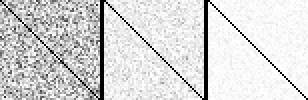

In [9]:
function dot_products_of_random_unit_vectors( vec_sz, num_vecs )
    Ω = randn(Float64, (vec_sz, num_vecs)) 
    for i in 1:num_vecs
        Ω[:,i] = Ω[:,i] / norm(Ω[:,i])   # Make cols of Ω have unit length
    end
    Ω'Ω
end
println( "Look at 50 vectors with increasing sizes: [10, 100, 1000]\n") 
mosaicview( [ Gray.((x->1-x).(abs.(dot_products_of_random_unit_vectors( vec_sz, 50)))) for vec_sz in [10, 100, 1000]]..., nrow=1, npad=2 )

## 2.2 Random Samples of the Column Space

In [10]:
# Sample the column Space
function approx_ColA( A, k )
    Aapprox = A * randn(Float64, (size(A,2), k))
    Matrix(qr(Aapprox).Q)
end;

Our `approx_ColA(A,n)` samples the column Space $\mathscr{C}(A)$ in roughly orthogonal directions<br>
$\qquad$ use QR orthogonalize the resulting samples: matrix $Q$

Sizes:
* $A$ is $M\times N$
* $Q$ is $M \times K$, where we want $K << N$  (long and skinny)

**Remark:** $A$ does not have to be in memory at the same time!

What happens when we project $A$ onto $Q$, i.e., when we compute $Q Q^t A$

Size A = (512, 768)
Sizes of Q = [10, 25, 100]



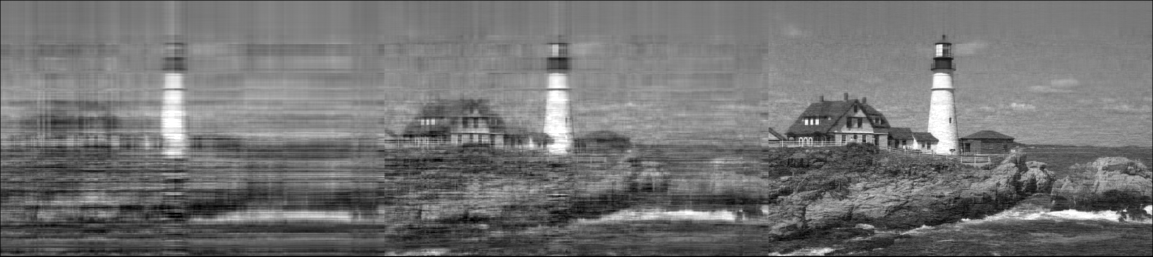

In [11]:
Aapprox_list = []
choice_of_K = [10,25,100]
for k in choice_of_K
    Q = approx_ColA( A, k)
    push!(Aapprox_list, Gray.(Q*Q'A) )   # project A onto Q
end
println( "Size A = ", size(A) )
println( "Sizes of Q = ", choice_of_K )
println()
mosaicview( Aapprox_list...; nrow=1)

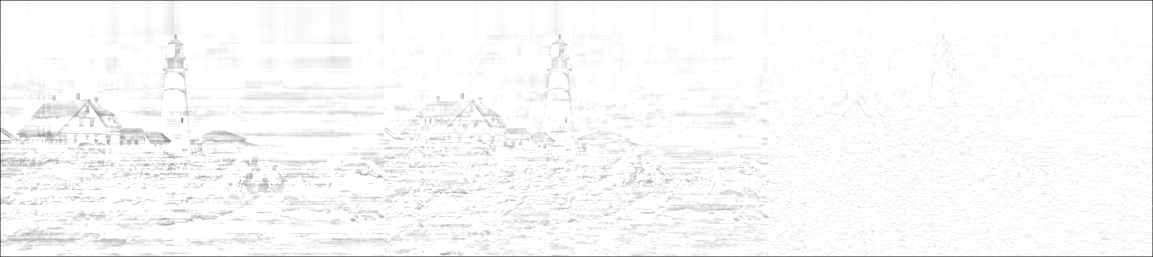

In [12]:
mosaicview( [(x->1-x).(img-gray) for img in Aapprox_list]...; nrow=1)

# 3. Matrix Factorizations

____
**Idea:** Approximate $A \approx Q Q^{t} A$, and apply matrix factorization algorithms to the much smaller $Q^t A$ rather than $A$.
* $A\qquad$ is $M\times N$
* $Q\qquad$ is $M\times K$, where $K << min(M,N)$
* $Q^t A\quad$ is $K \times N$ 

Consider the SVD decomposition $A = U \Sigma V^t$.<br>
$\quad$ Then $Q^t A = Q^t U \Sigma V^t = \tilde{U} \Sigma V^t,$<br>
$\quad$ so that the SVD of $Q^t A$ and the SVD of $A$ are related:<br>
* they have the same singular values $\Sigma$ and the same singular vectors in $V$.
* the singular vectors $\tilde{U}$ of $Q^t A$ are related to the singular vectors $U$ of $A$ by
$U = Q^t \tilde{U}$

# 4. Randomized SVD

Suppose we can find an orthogonal matrix $Q$ such that $A \approx Q Q^t A$,<br>
we can use this approximation to compute an approximate matrix decomposition of $A$.

Matrix Sizes:
* Let $A$ have size $M \times N$
* Let $Q$ have size $M \times K$, where $K < N$.
* Then $Q^t A$ has size $K \times N$. potentially much smaller that the original matrix.

* The $\tilde{U}$ matrix of our SVD has size $K \times K$. (The original matrix $U$ is $N \times N$

How to choose $K$?  Usually, $K = rank(A) + l,$ where $l \approx 5$.

In [13]:
function randomized_svd(A; k=5, may_transpose = false)
    if may_transpose
        transpose = size(A,1) < size(A,2)
        if transpose A = A' end
    end

    Q   = approx_ColA( A, k )
    QtA = Q'A

    svd_QtA = svd( QtA )
    U       = Q * svd_QtA.U

    if may_transpose && transpose
        SVD( svd_QtA.V, svd_QtA.S, Matrix(U') )
    else
        SVD( U, svd_QtA.S, svd_QtA.V' )
    end
end
function svdErr( svdA, A )
    norm( svdA.U * diagm( svdA.S ) * svdA.Vt  - A )
end

K=100
println( "Matrix size:    ", size(A) )
println( ".  choice of K: ", K )
svdA  = randomized_svd(A'; k=K)
@show svdErr( svdA, A' );

Matrix size:    (512, 768)
.  choice of K: 100
svdErr(svdA, A') = 28.237953014836226


## 4.1 Randomized SVD

____
**Idea:** Power $(A^t A)^p A$ changes the distribution of the singular values

$  \begin{align} A = U \Sigma V^t \Rightarrow
\left( A A^t \right)^p A &= \left( U \Sigma \Sigma^t U^t \right)^p \left( U \Sigma V^t \right) \\
&= U_r \Sigma^{p+1}_r V^t_r  
\end{align}.$

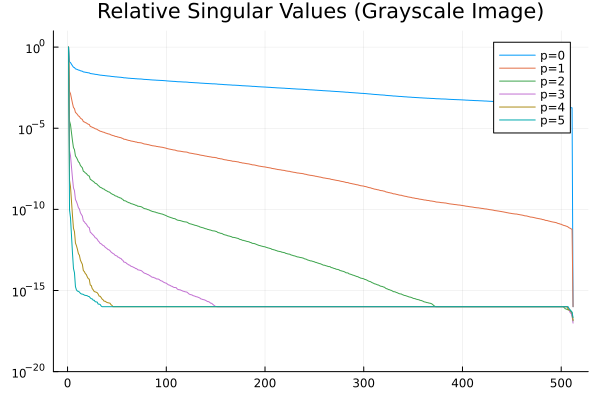

In [28]:
svdA = svd(A)
plot(  svdA.S/svdA.S[1], yscale=:log10, label="p=0", ylim=(1e-20,10)  )
Z = A
for p in 1:5
    Z    = A * (A'Z)
    svdZ = svd(Z)
    plot!( svdZ.S / svdZ.S[1], yscale=:log10, label="p=$p"  )
end
title!( "Relative Singular Values (Grayscale Image)") 

## 4.2 Randomized SVD with Power

Matrix size:    (512, 768)
.  choice of K: 100
.  svdErr as a function of the power


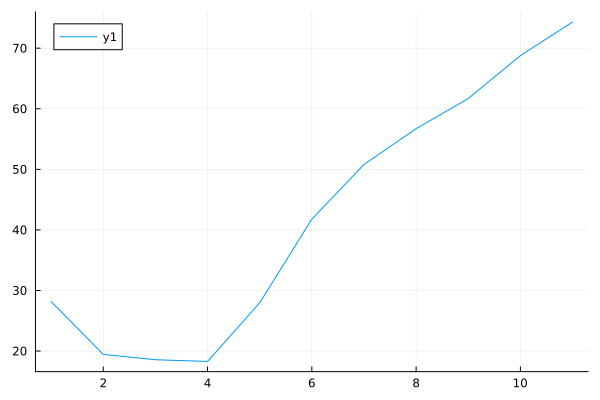

In [32]:
function approxCol_Ap( A, p, k)
    Aapprox = A * randn(Float64, (size(A,2), k))
    for n in 1:p
        Aapprox = A * ( A'Aapprox)    # Z = (A A.T)^p A v
    end
    Matrix(qr(Aapprox).Q)
end
function randomized_svd_Ap(A; p=3, k=5)
    Q   = approxCol_Ap( A, p, k )
    QtA = Q'A

    svd_QtA = svd( QtA )
    U       = Q * svd_QtA.U

    SVD( U, svd_QtA.S, svd_QtA.V' )
end

K=100
println( "Matrix size:    ", size(A) )
println( ".  choice of K: ", K )
println( ".  svdErr as a function of the power" )
err = [svdErr( randomized_svd_Ap(A'; p, k=K), A' ) for p in 0:10]
plot(err)

https://www.youtube.com/watch?v=mQlzdDTRJpU
https://www.youtube.com/watch?v=dyeSHiwntxY